# Plotting Flux. vs. Photon Shooting

### Changes from Last Week:
* ability to choose between multiple PSFs, using the default values found in the GalSim documentation
* a modified `timeit` routine that allows the user to compute an average time by specifying the number of runs of a routine
    * if more than 1 run is chosen, the object returned by the last run is used for future calculations
* a varied half light radius in the setup routine to see if GalSim is doing any caching. 
    * Done by choosing a random float from $[0, 0.05]$ and adding that to the current half-light-radius value of 1.0


In [1]:
import sys
import os
import math
import logging
import galsim
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## timeit routine

In [2]:
def timeit(func, repeat:int = 1):
    import time
    """
    Takes in a function func and runs and times it on the arguments in *args
    Then outputs the output of func(*args) and the time taken.
    If repeat is true, it repeats the routine and produces the average value
    """
    if repeat == 0:
        raise ValueError("repeat parameter cannot be 0")

    def timeit_wrapper(*args, **kwargs):
        average = 0

        for _ in range(repeat):

            tstart = time.time()
            res = func(*args, **kwargs)
            tend = time.time()
            duration = tend-tstart

            average += duration

        average /= repeat

        return res, average

    return timeit_wrapper


## setup

In [3]:
## Init ##

# Initialize the logger
logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger("demo7")

random_seed = 1534225

gal_flux = 1.e5 # counts
rng = galsim.BaseDeviate(random_seed + 1)
gal_r0 = 2.7 # arcseconds
psf_beta = 5
pixel_scale = 0.2
psf_re = 1.0 # arcsec

nx = 64
ny = 64

# Obtaining setup start time to obtain fixed costs for setting up
# a particular type of profile.

num_gals = 4

# Creates linearly and logarithmically spaced flux values
fluxs = np.linspace(1.e3, 1.e7, 15)
log_fluxs = np.logspace(3, 7, 15)

# Identify the flux scale used
# Uncomment one or the other to use one or the other throughout the code.

flux_scale = fluxs
# flux_scale = log_fluxs


# Plotting setup times
galaxy_names = ["Exponential", "Gaussian", "DeVaucouleurs", "Sersic"]

## timing initialization 

With a random half_light_radius offset.


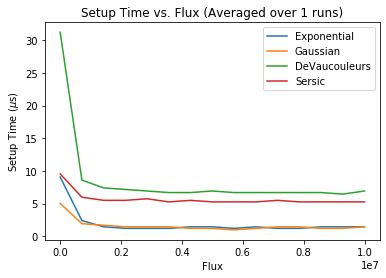

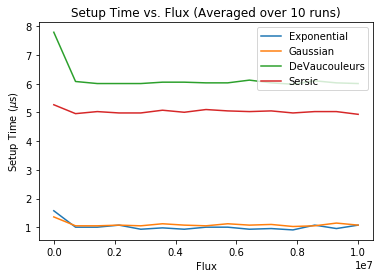

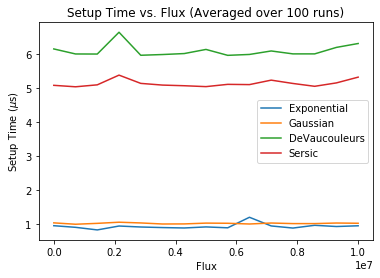

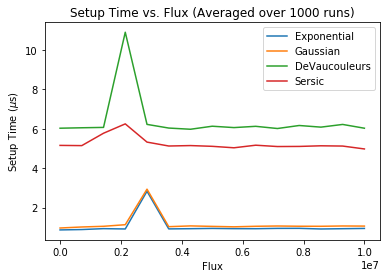

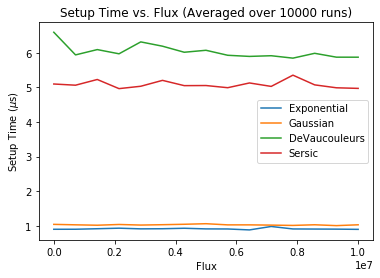

<Figure size 432x288 with 0 Axes>

In [4]:
# An array to store fluxs. This array is 15x4, where 15 is the number
# flux values that we are using. There are 4 columns because that is the number of
# galaxies.
setup_times_vary_flux = np.zeros((num_gals, len(flux_scale)))


# Stores the random offsets introduced in generating the times for each iteration of the flux.
offsets = []

def time_init(repeat):
    # Each index stores the 4 galaxies at different flux indices.
    gals_flux = []

    for i, gal_flux in enumerate(flux_scale):
        # Storing the setup times for each galaxy

        # Using different galaxy profiles
        # Adding a random offset to the half_light_radius parameter to make sure that GalSim isn't
        # caching anything.
        random_offset = np.random.random_sample() / 20 # generates a random number between [0, 0.05)
        # random_offset = 0

        gal_exp, time_exp_gal = timeit(galsim.Exponential, repeat=repeat) (half_light_radius = 1 + random_offset , flux=gal_flux)
        gal_gauss, time_gauss_gal = timeit(galsim.Gaussian, repeat=repeat) (half_light_radius = 1 + random_offset, flux=gal_flux)
        gal_devauc, time_devauc_gal = timeit(galsim.DeVaucouleurs, repeat=repeat) (half_light_radius = 1 + random_offset, flux=gal_flux)
        gal_sers, time_sers_gal = timeit(galsim.Sersic, repeat=repeat) (half_light_radius = 1 + random_offset, flux=gal_flux, n=2.5)

        # Updating the offsets
        offsets.append(random_offset)

        # Store the generated galaxy for each flux value
        gals_flux.append([gal_exp, gal_gauss, gal_devauc, gal_sers])

        # Adding all the times to the setup time list
        setup_times_vary_flux[0, i] = time_exp_gal
        setup_times_vary_flux[1, i] = time_gauss_gal
        setup_times_vary_flux[2, i] = time_devauc_gal
        setup_times_vary_flux[3, i] = time_sers_gal
        


    # Plotting setup times
    plt.title("Setup Time vs. Flux (Averaged over %d runs)" % repeat)
    plt.xlabel("Flux")
    plt.ylabel(r"Setup Time ($\mu$s)")

    for i in range(num_gals):
        plt.plot(flux_scale, setup_times_vary_flux[i] * 10**6, label=galaxy_names[i])

    plt.legend()
    plt.show()
    plt.figure()
    
    return gals_flux

logger.info("With a random half_light_radius offset.")
time_init(repeat=1)
time_init(repeat=10)
time_init(repeat=100)
time_init(repeat=1000)
gals_flux = time_init(repeat=10000)

## initializing PSFs

In [5]:
# Using example values specified in the documentation
# Defining lambda, r0, and telescope diameter
lam = 700
diam = 3
r0 = 0.15 * (lam/500)**1.2 # meters

# Define different PSFs and use the cur_psf variable to perform our convolutions
kolmogorov_psf, kolmogorov_psf_time = timeit(galsim.Kolmogorov) (lam=lam, r0=r0, scale_unit=galsim.arcsec)
vonkarman_psf, von_karman_psf_time = timeit(galsim.VonKarman) (lam=lam, r0=r0)
airy_psf, airy_psf_time = timeit(galsim.Airy) (lam=lam, diam=diam)
moffat_psf, moffat_psf_time = timeit(galsim.Moffat) (beta=psf_beta, flux=1., half_light_radius=psf_re)
optical_psf, optical_psf_time = timeit(galsim.OpticalPSF) (lam=lam, diam=diam)

cur_psf = moffat_psf

## running and timing convolutions + drawings

In [7]:
# final profile (these are galsim.Convolution objects)
finals = []

# Stores the time it takes to do a convolution with various galaxies at
# different fluxs. This is a 15x4 array where at each galaxy generated at a
# given flux level, we compute the time required to do a convolution with the Moffat PSF.
convolution_times = np.zeros((num_gals, len(flux_scale)))
final_times = np.zeros((num_gals, len(flux_scale)))

def draw_compute_times(psf):

    # For each kind of galaxy, we time the convolution
    for gals_flux_ind, gals in enumerate(gals_flux):
        finals_at_flux = []
        logger.info("gals_flux_index: %d", gals_flux_ind)
        flux_val = flux_scale[gals_flux_ind]
        flux_ind = gals_flux_ind

        for gal_ind, gal in enumerate(gals):
            
            # Since the convolution is done lazily, this method doesn't really need to be timed.
            # The convolution happens when we call drawImage
            # This method just creates an object that we can use to draw.
            # The actual convolution is timed a few lines below in the line with "cnvl_img_final.drawImage"
            cnvl_img_final = galsim.Convolve([gal, psf])
            finals_at_flux.append(cnvl_img_final)

            image = galsim.ImageF(2*nx+2, ny, scale=pixel_scale)
            phot_image = image[galsim.BoundsI(nx+3, 2*nx+2, 1, ny)]

            img, draw_img_time = timeit(cnvl_img_final.drawImage) (phot_image, method="phot", rng=rng)
            final_times[gal_ind, flux_ind] = draw_img_time
            
    return final_times

final_times_psfs = []
names = [
    "Kolmogorov PSF",
    "VonKarman PSF",
    "Airy PSF",
    "Moffat PSF",
    "Optical PSF"
]

# Computing the times for all possible PSFs
for name, psf in zip(names, [kolmogorov_psf, vonkarman_psf, airy_psf, moffat_psf, optical_psf]):
    logger.info(name)
    final_times_psfs.append(draw_compute_times(psf))
    

Kolmogorov PSF
gals_flux_index: 0
gals_flux_index: 1
gals_flux_index: 2
gals_flux_index: 3
gals_flux_index: 4
gals_flux_index: 5
gals_flux_index: 6
gals_flux_index: 7
gals_flux_index: 8
gals_flux_index: 9
gals_flux_index: 10
gals_flux_index: 11
gals_flux_index: 12
gals_flux_index: 13
gals_flux_index: 14
VonKarman PSF
gals_flux_index: 0
gals_flux_index: 1
gals_flux_index: 2
gals_flux_index: 3
gals_flux_index: 4
gals_flux_index: 5
gals_flux_index: 6
gals_flux_index: 7
gals_flux_index: 8
gals_flux_index: 9
gals_flux_index: 10
gals_flux_index: 11
gals_flux_index: 12
gals_flux_index: 13
gals_flux_index: 14
Airy PSF
gals_flux_index: 0
gals_flux_index: 1
gals_flux_index: 2
gals_flux_index: 3
gals_flux_index: 4
gals_flux_index: 5
gals_flux_index: 6
gals_flux_index: 7
gals_flux_index: 8
gals_flux_index: 9
gals_flux_index: 10
gals_flux_index: 11
gals_flux_index: 12
gals_flux_index: 13
gals_flux_index: 14
Moffat PSF
gals_flux_index: 0
gals_flux_index: 1
gals_flux_index: 2
gals_flux_index: 3
gals_

## plot draw times

Kolmogorov PSF
VonKarman PSF
Airy PSF
Moffat PSF


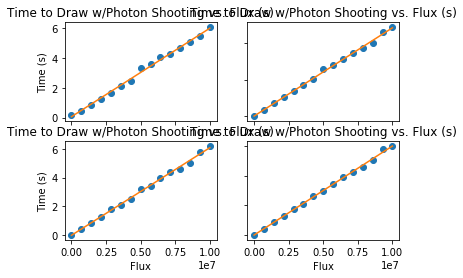

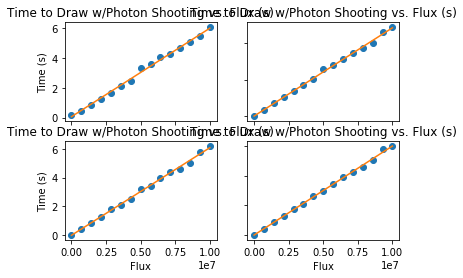

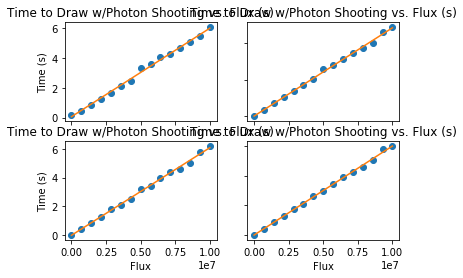

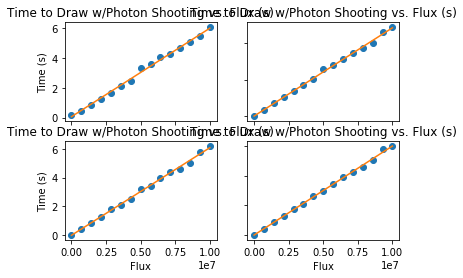

In [17]:
def plot_times(times):

    # Obtaining the fixed setup costs for a given type of profile
    # Currently, we're only doing Exponential galaxy profiles with Moffat psfs
    
    fig, axs = plt.subplots(2, 2)
    for i in range(num_gals):
        
        if i == 0: 
            x, y = 0, 0
        elif i == 1:
            x, y = 0, 1
        elif i == 2:
            x, y = 1, 0
        elif i == 3:
            x, y = 1, 1
        else:
            raise ValueError("invalid x and y")
        
        axs[x, y].set_title("Time to Draw w/Photon Shooting vs. Flux (s)")
        axs[x, y].scatter(flux_scale, final_times[i], label=galaxy_names[i])
        
        # Doing a linear regression and finding a slope and R value for the flux and the times
        slope, intercept, r_value, p_value, stderr = stats.linregress(flux_scale, final_times[i])
        axs[x, y].plot(flux_scale, intercept + slope * flux_scale, 'tab:orange', label=galaxy_names[i])
        
        for ax in axs.flat:
            ax.set(xlabel="Flux", ylabel="Time (s)")
            
        for ax in axs.flat:
            ax.label_outer()

for name, times in zip(names, final_times):
    logger.info(name)
    plot_times(times)